In [63]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [64]:
# from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [65]:
# Load the images
cat_img = cv2.imread('/content/drive/MyDrive/EE200 Project/Problem1/cat_gray.jpg')

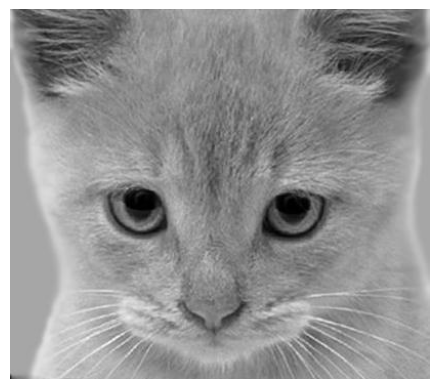

In [66]:
plt.axis('off')
plt.imshow(cat_img)

In [67]:
# defined a function to plot magnitude spectrum and db spectrum using dft of a signal
def plotdft(dft, title):
  magnitude_spectrum = cv2.magnitude(dft[:,:,0], dft[:,:,1])
  db_spectrum = 20 * np.log10(magnitude_spectrum+1)
  fig = plt.figure(figsize=(12,12))
  ax1 = fig.add_subplot(2,2,1)
  ax1.imshow(magnitude_spectrum, cmap='gray')
  ax1.title.set_text(f'{title} - Magnitude Spectrum')
  ax2 = fig.add_subplot(2,2,2)
  ax2.imshow(db_spectrum, cmap='gray')
  ax2.title.set_text(f'{title} - dB Spectrum')
  plt.tight_layout()
  plt.show()

without shifting

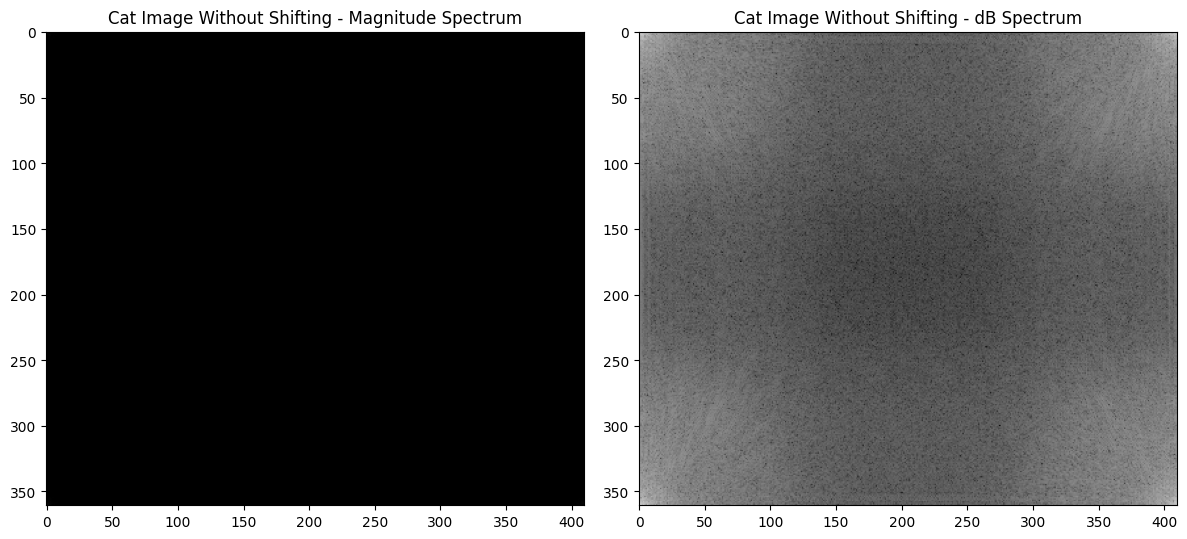

In [68]:
# image is by default 3 channel, convert the image to grayscale (single channel)
# cv2.dfd expects a single or double channel array of 32 bit
cat_img_gray = cv2.cvtColor(cat_img, cv2.COLOR_BGR2GRAY)

# Apply DFT to the single-channel grayscale image
dft = cv2.dft(np.float32(cat_img_gray), flags=cv2.DFT_COMPLEX_OUTPUT)
plotdft(dft, 'Cat Image Without Shifting')


# the spectrum is centered at the top left corner

**with shifting**

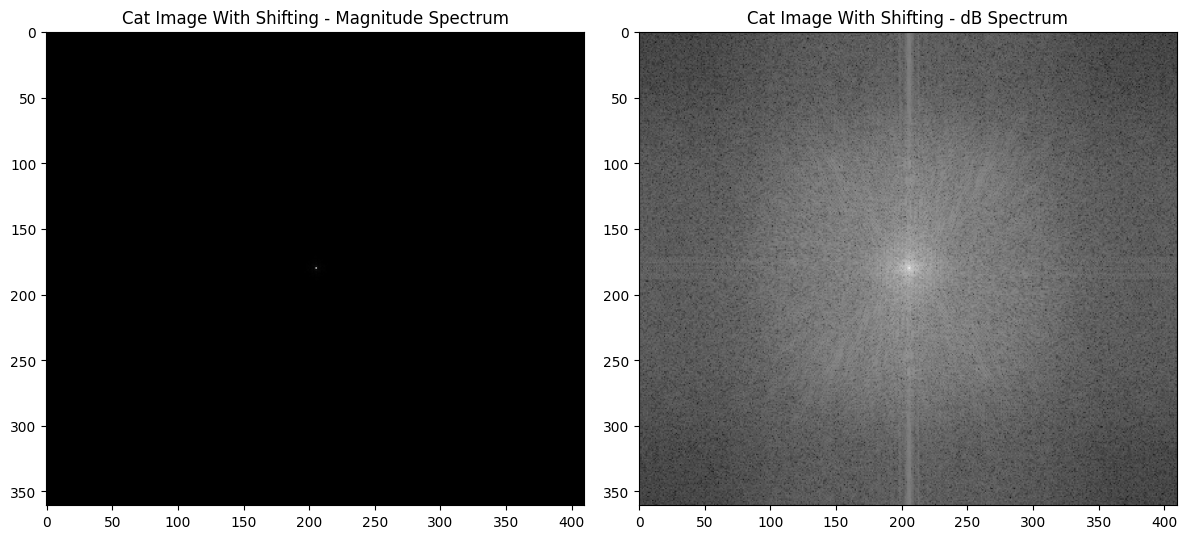

In [69]:
# Shift it to make lower frequencies located at center of 2D transform.
dft_shifted = np.fft.fftshift(dft)
plotdft(dft_shifted, 'Cat Image With Shifting')

#now the center is shifted to the center of the plot

90 degree anticlockwise rotation and then plotting the FT magnitude spectrum

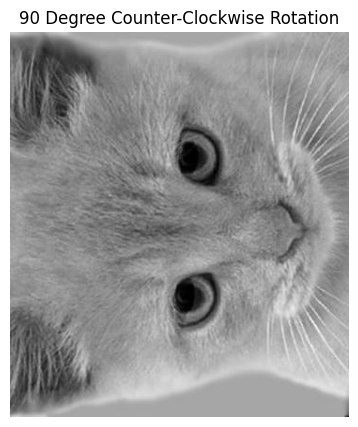

In [70]:
# Rotate the image using np.rot90
cat_img_rot90 = np.rot90(cat_img, k=1) # k=1 for 90 degrees counter-clockwise
# cat_img_rot90 = cat_img_gray.rotate(90)
# Display the rotated image
plt.figure(figsize=(12, 5))
plt.imshow(cv2.cvtColor(cat_img_rot90, cv2.COLOR_BGR2RGB)) # Convert BGR to RGB for correct display
plt.title('90 Degree Counter-Clockwise Rotation')
plt.axis('off')
plt.show()

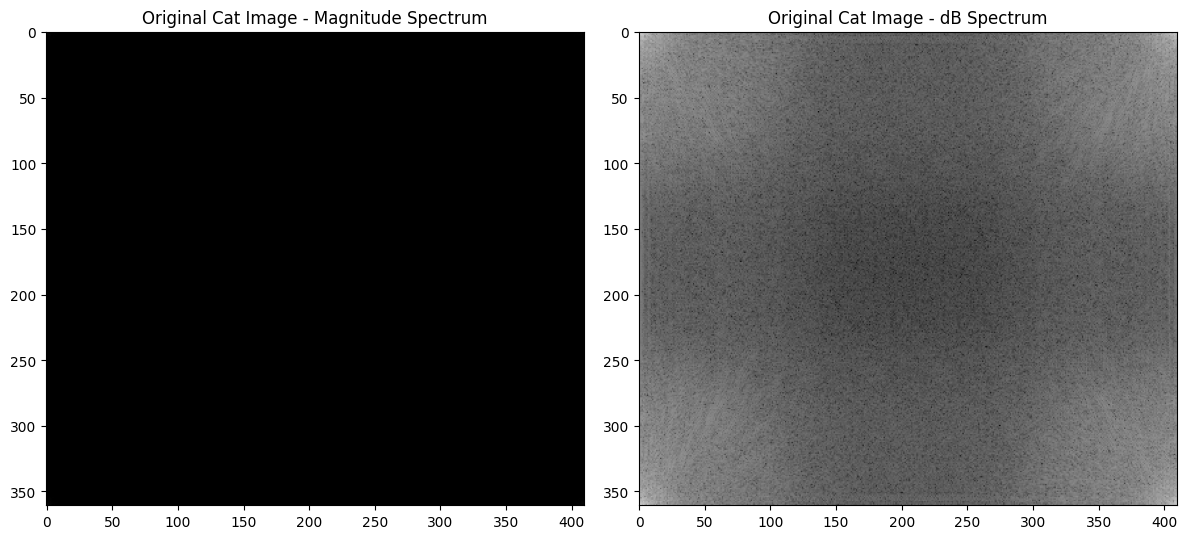

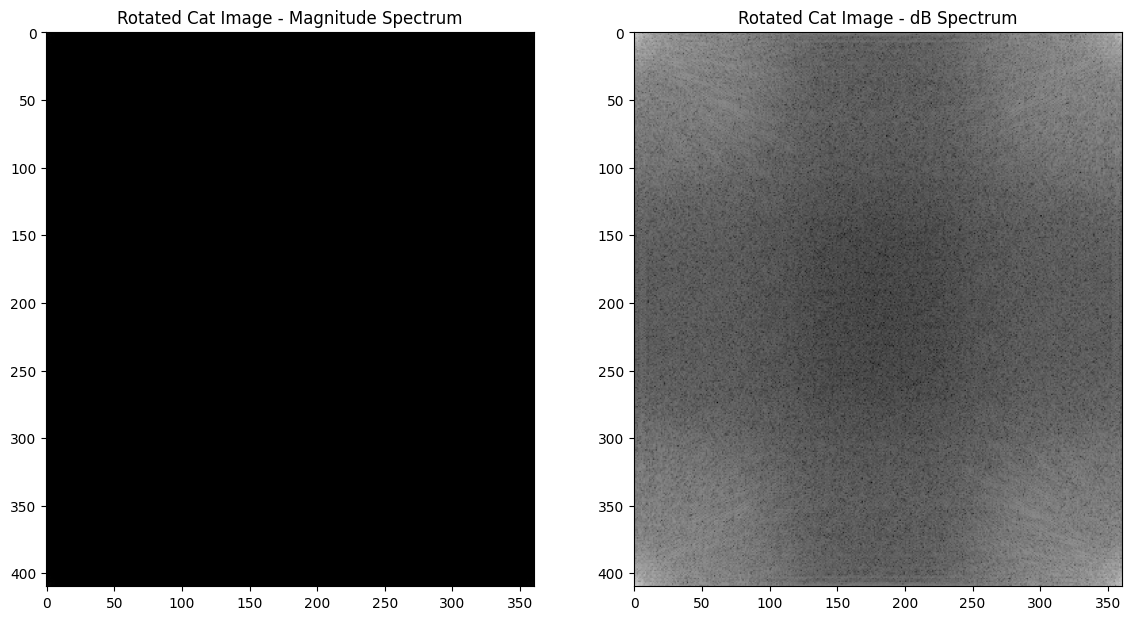

In [71]:
# dft_rot90 = cat_img_rot90
cat_img_rot90_gray = cv2.cvtColor(cat_img_rot90, cv2.COLOR_BGR2GRAY)
dft_rot90 = cv2.dft(np.float32(cat_img_rot90_gray), flags=cv2.DFT_COMPLEX_OUTPUT)
plotdft(dft, 'Original Cat Image')
plotdft(dft_rot90, 'Rotated Cat Image')

# center at top left

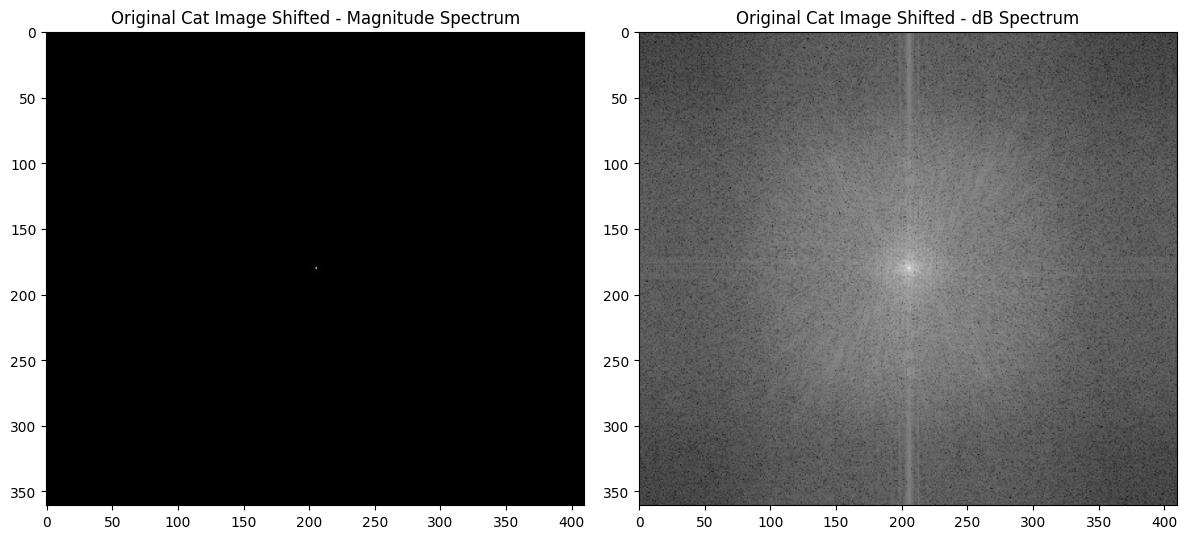

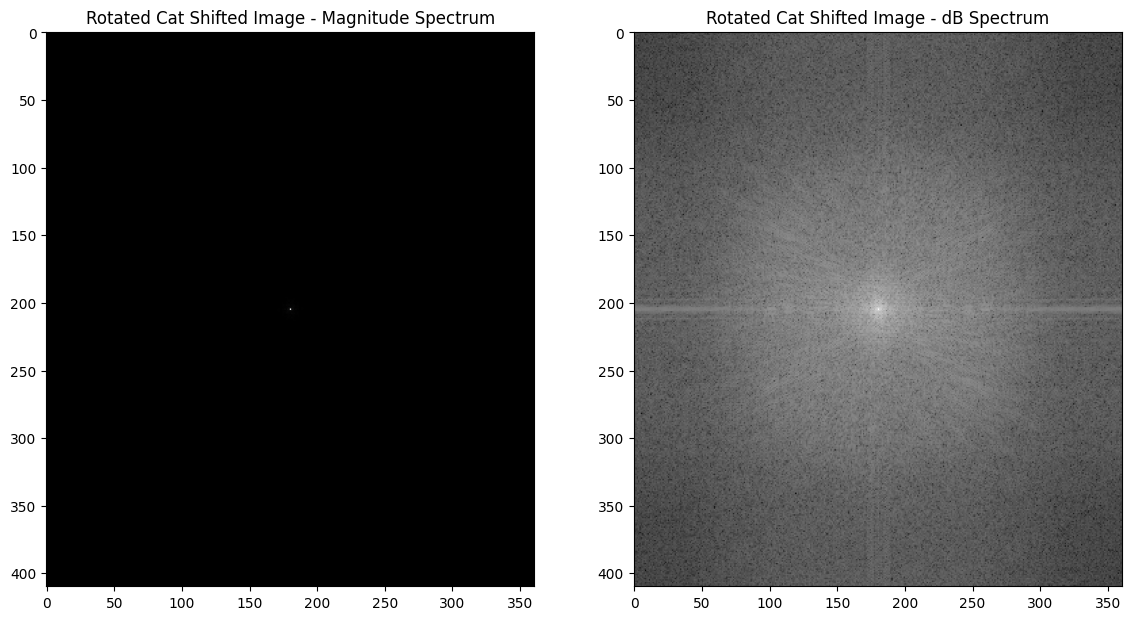

In [72]:
# cat_img_rot90_gray = cv2.cvtColor(cat_img_rot90, cv2.COLOR_BGR2GRAY)
dft_rot90 = cv2.dft(np.float32(cat_img_rot90_gray), flags=cv2.DFT_COMPLEX_OUTPUT)
# Shift it to make lower frequencies located at center of 2D transform.
dft_rot90_shifted = np.fft.fftshift(dft_rot90)
# plotdft(dft_rot90_shifted, 'Cat Image With Shifting')
plotdft(dft_shifted, 'Original Cat Image Shifted')
plotdft(dft_rot90_shifted, 'Rotated Cat Shifted Image')

# it is evident from the plots that the fourier transform has rotated by the same amount as the image has rotated.

Designing and Implementing the Frequency Mixer

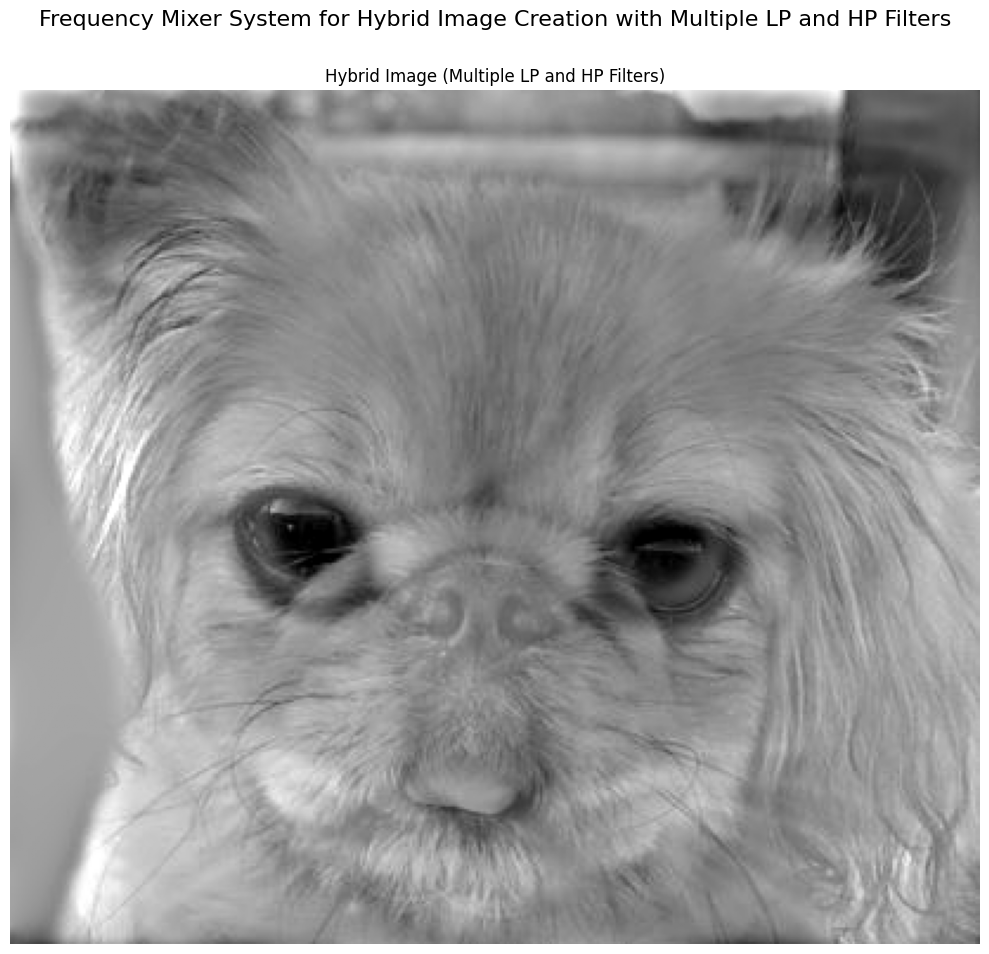

In [79]:
# Load the dog image using cv2
img_dog_gray = cv2.imread('/content/drive/MyDrive/EE200 Project/Problem1/dog_gray.jpg', cv2.IMREAD_GRAYSCALE)

# Standardize sizes by resizing the cat image to match the dog image using cv2
# Resize cat_img_gray to the shape of img_dog_gray
img_cat_resized = cv2.resize(cat_img_gray, (img_dog_gray.shape[1], img_dog_gray.shape[0]))

# Convert images to float32 for calculations
img_dog = np.float32(img_dog_gray)
img_cat = np.float32(img_cat_resized)

# Design Filters
M, N = img_dog.shape

# Create a frequency grid that matches the layout of np.fft.fft2 output
# This is a robust method that avoids shifting errors during calculation.
x_freq = np.fft.fftfreq(N)
y_freq = np.fft.fftfreq(M)
xv, yv = np.meshgrid(x_freq, y_freq)
# the distance in the frequency domain using the sum of squares
D = np.sqrt(xv**2 + yv**2)

# Define multiple cutoff frequency pairs for low-pass and high-pass filters
low_pass_cutoffs = [5, 35, 25]  # Example low-pass cutoffs
high_pass_cutoffs = [10, 13, 3] # Example high-pass cutoffs

# Apply Filters and Mix Images

# Get the 2D FFT of both images
fft_dog = np.fft.fft2(img_dog)
fft_cat = np.fft.fft2(img_cat)

# Initialize filtered images
img_cat_low_total = np.zeros_like(img_cat)
img_dog_high_total = np.zeros_like(img_dog)


# Apply multiple low-pass filters to the cat image and sum the results
for cutoff_low in low_pass_cutoffs:
    H_lp = np.exp(-(D**2) / (2 * (cutoff_low/N)**2))
    low_pass_filtered_fft = fft_cat * H_lp
    img_cat_low = np.real(np.fft.ifft2(low_pass_filtered_fft))
    img_cat_low_total += img_cat_low

# Apply multiple high-pass filters to the dog image and sum the results
for cutoff_high in high_pass_cutoffs:
    H_hp = 1 - np.exp(-(D**2) / (2 * (cutoff_high/N)**2))
    high_pass_filtered_fft = fft_dog * H_hp
    img_dog_high = np.real(np.fft.ifft2(high_pass_filtered_fft))
    img_dog_high_total += img_dog_high

# Combine the low-frequency cat components with the high-frequency dog components.
# Normalize the combined images by the number of filters applied to each.
hybrid_image = np.clip((img_cat_low_total / len(low_pass_cutoffs)) + (img_dog_high_total / len(high_pass_cutoffs)), 0, 255)

# Visualization
plt.figure(figsize=(10, 10))

# Plot Hybrid Image using matplotlib's imshow
plt.imshow(hybrid_image.astype(np.uint8), cmap='gray') # Convert back to uint8 for display
plt.title(f'Hybrid Image (Multiple LP and HP Filters)')
plt.axis('off')


plt.suptitle('Frequency Mixer System for Hybrid Image Creation with Multiple LP and HP Filters', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

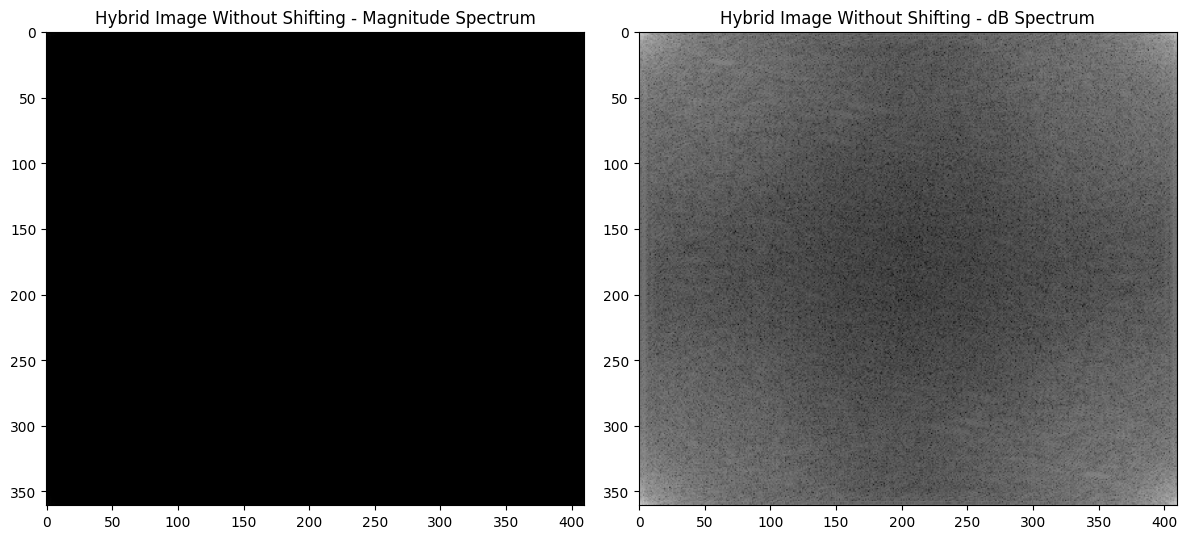

In [78]:
dft_hybrid = cv2.dft(np.float32(hybrid_image), flags=cv2.DFT_COMPLEX_OUTPUT)
plotdft(dft_hybrid, 'Hybrid Image Without Shifting')

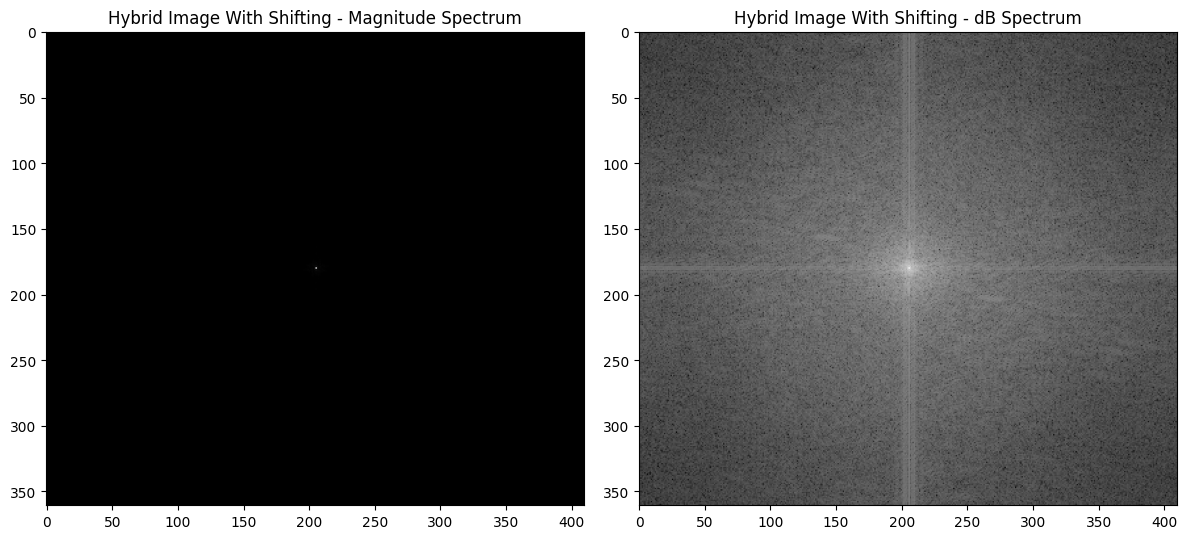

In [75]:
# Shift it to make lower frequencies located at center of 2D transform.
dft_hybrid_shifted = np.fft.fftshift(dft_hybrid)
plotdft(dft_hybrid_shifted, 'Hybrid Image With Shifting')